In [7]:
from datetime import datetime, date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [8]:
# Constants
INPUT_DATA_PATH = "/kaggle/input/ashrae-energy-prediction"

MIN_TRAIN_TIMESTAMP = pd.Timestamp("2016-01-01 00:00:00")
MAX_TRAIN_TIMESTAMP = pd.Timestamp("2016-12-31 23:00:00")
TRAIN_DATA_RESOLUTION = "1h"

In [9]:
# Load meter readings
readings_df = pd.read_csv(
    f"{INPUT_DATA_PATH}/train.csv",
    header=0,
    names=["building_id", "meter_id", "timestamp", "meter_reading"],
)
readings_df["timestamp"] = pd.to_datetime(readings_df["timestamp"])
readings_df["ln_meter_reading"] = np.log1p(readings_df["meter_reading"])

## Electricity Readings

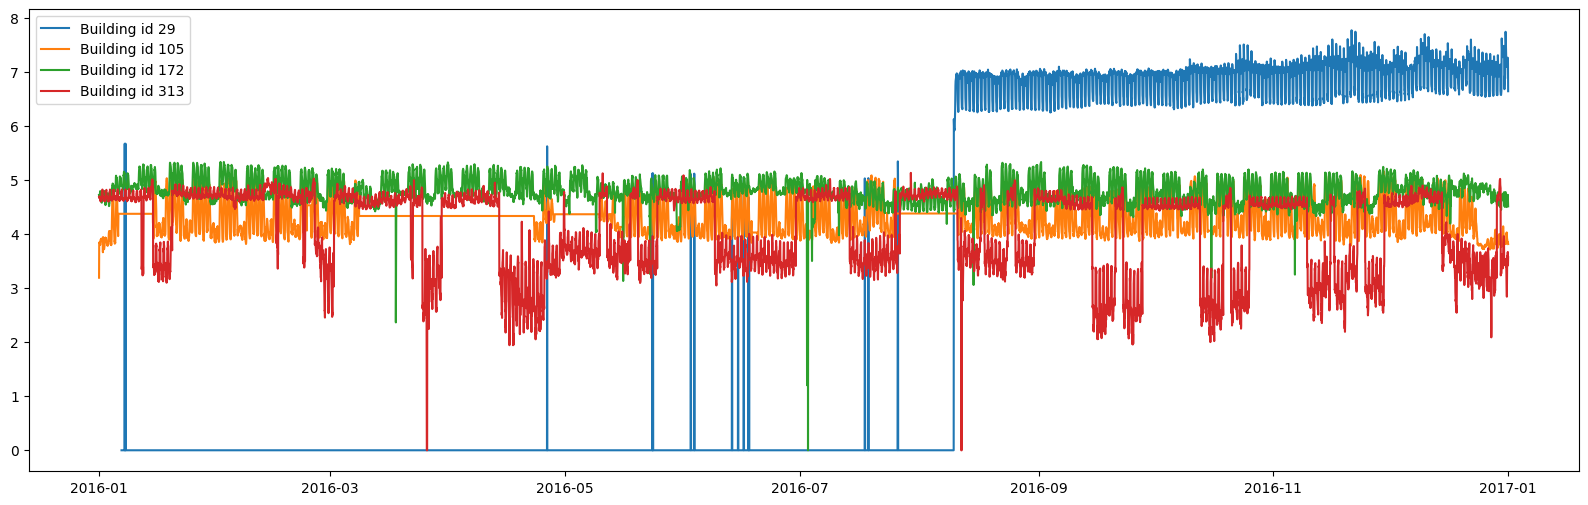

In [10]:
# meter_id: type -> {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}

meter_id = 0
building_ids = [29, 105, 172, 313]

df = readings_df[(readings_df["building_id"].isin(building_ids)) & (readings_df["meter_id"] == meter_id)]

fig, ax = plt.subplots(1, 1, figsize=(20, 6))
for b_id in building_ids:
    b_df = df[df["building_id"] == b_id]
    ax.plot(
        b_df["timestamp"].values,
        b_df["ln_meter_reading"].values,
        label=f"Building id {b_id}",
    )

ax.legend()

### Filter on timestamps

In [11]:
def construct_keep_filter(
    timestamps: pd.Series,
    to_keep: list[tuple[datetime | None, datetime | None]],
):
    filter_ = False 
    for start, end in to_keep:
    
        match (start, end):
            case None, None:
                pass
            case (datetime(), None):
                period_filter = timestamps >= start
            case (None, datetime()):
                period_filter = timestamps <= end
            case (datetime(), datetime()):
                period_filter = (timestamps >= start) & (timestamps <= end)
        
        filter_ |= period_filter
    
    return filter_


def to_keep_filter(
    data: pd.DataFrame,
    to_keep: list[tuple[datetime | None, datetime | None]]
):
    keep_filter = construct_keep_filter(data["timestamp"], to_keep)
    return data.loc[keep_filter]

In [12]:
def find_constant_streaks(
    df: pd.DataFrame,
    streak_length: int = 10,
    target_column: str = "ln_meter_reading"
):
    # Compute diffs on target col
    df = df.copy()
    df = df.sort_values("timestamp")
    df["target_col_diff"] = df[target_column].diff()
    
    # First find any periods of constant meter readings
    streaks = []
    current_streak_start = 0
    for idx, row in df.iterrows():
        if pd.isna(row["target_col_diff"]):
            continue
        
        elif row["target_col_diff"] == 0:
            # Start a new streak if not already a running streak
            current_streak_start = current_streak_start or idx - 1
        
        else:
            # Streak finished
            # Save if there is currently a running streak
            if current_streak_start is not None:
                streaks.append((current_streak_start, idx - 1))
    
            # Reset
            current_streak_start = None
            

    # Only keep streaks with length >= streak_length
    filtered_streaks = []
    for start, end in streaks:
        streak_df = df.loc[start: end]
        assert (streak_df["target_col_diff"].dropna() == 0).all(), print(start, end)
        if len(streak_df) >= streak_length:
            start_t = streak_df["timestamp"].min().to_pydatetime()
            end_t = streak_df["timestamp"].max().to_pydatetime()
            filtered_streaks.append((start_t, end_t))
    
    return filtered_streaks

In [13]:
# Apply to all electricity data

def filter_electricity_data(
    readings_df: pd.DataFrame,
    to_keep_filters: dict[int, list[tuple[datetime | None, datetime | None]]],
):
    meter_id = 0
    for b_id, b_filter in tqdm(to_keep_filters.items()):
        bm_df = readings_df[
            (readings_df["building_id"] == b_id)
            & (readings_df["meter_id"] == meter_id)
        ]
        bm_df_filtered = to_keep_filter(bm_df, b_filter)
        readings_df = readings_df.drop(bm_df.index)
        readings_df = pd.concat([readings_df, bm_df_filtered], axis=0)
    return readings_df

In [ ]:
readings_before = readings_df.copy()
readings_after = filter_electricity_data(readings_df, to_keep_electricity)

## Chilled Water

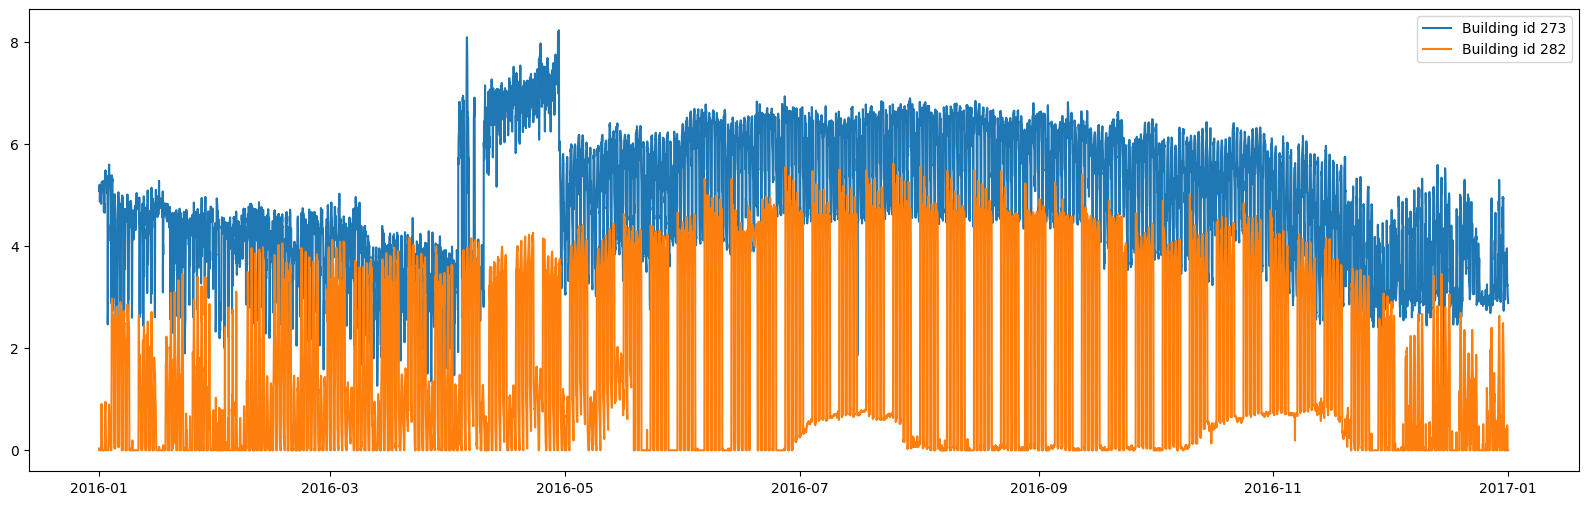

In [14]:
# meter_id: type -> {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}

meter_id = 1
start_id = 1410
building_ids = [273, 282]

df = readings_df[(readings_df["building_id"].isin(building_ids)) & (readings_df["meter_id"] == meter_id)]

fig, ax = plt.subplots(1, 1, figsize=(20, 6))
for b_id in building_ids:
    b_df = df[df["building_id"] == b_id]
    ax.plot(
        b_df["timestamp"].values,
        b_df["ln_meter_reading"].values,
        label=f"Building id {b_id}",
    )

ax.legend()
fig.tight_layout();

## Steam

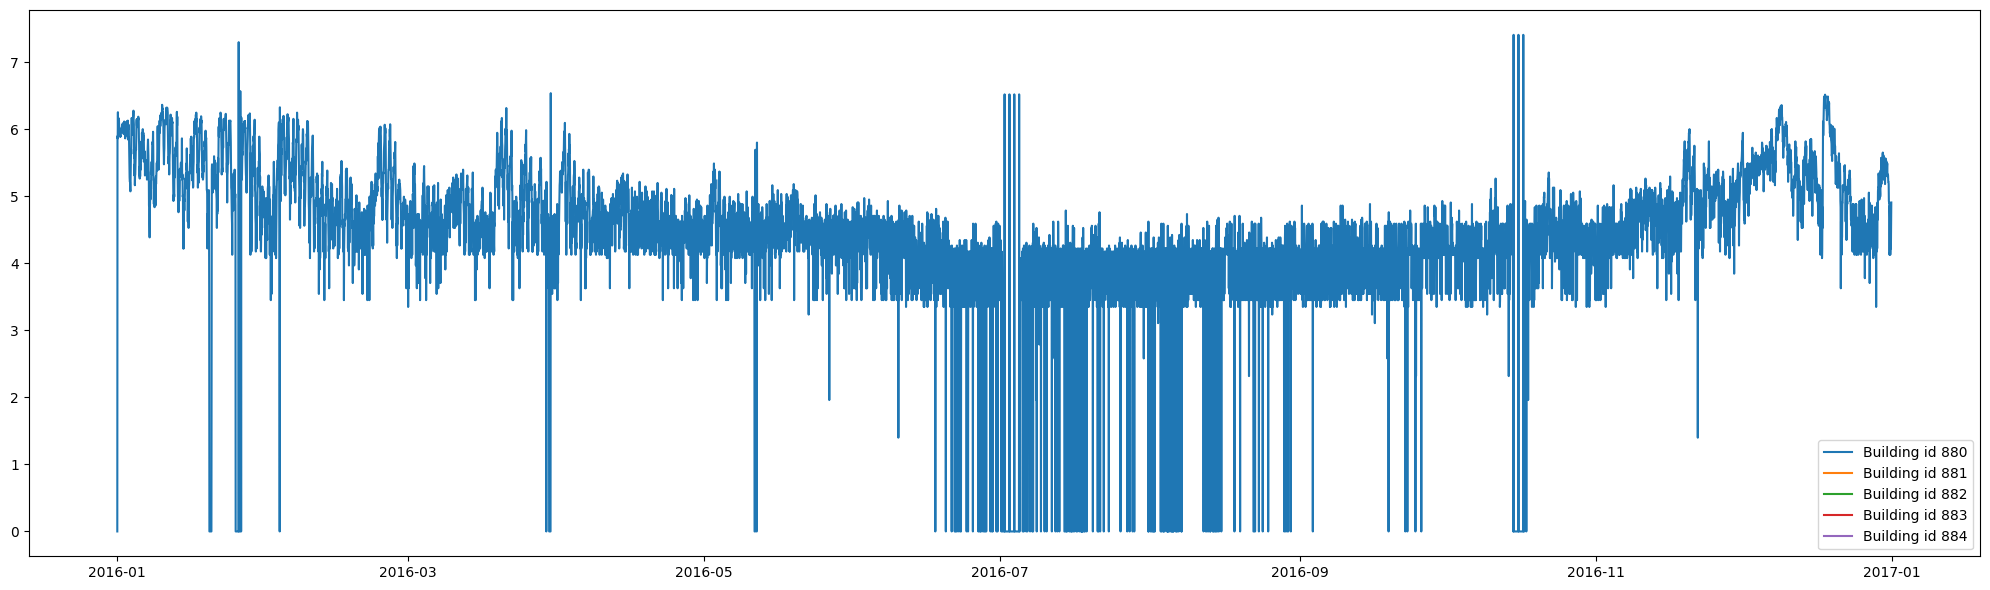

In [68]:
# meter_id: type -> {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}

meter_id = 2
start_id = 880
building_ids = list(range(start_id, start_id + 5))

bm_df = readings_df[(readings_df["building_id"].isin(building_ids)) & (readings_df["meter_id"] == meter_id)]

fig, ax = plt.subplots(1, 1, figsize=(20, 6))
for b_id in building_ids:
    b_df = bm_df[bm_df["building_id"] == b_id]
    ax.plot(
        b_df["timestamp"].values,
        b_df["ln_meter_reading"].values,
        label=f"Building id {b_id}",
    )

ax.legend()
fig.tight_layout();

2016-10-15 00:00:00 2016-10-17 06:00:00


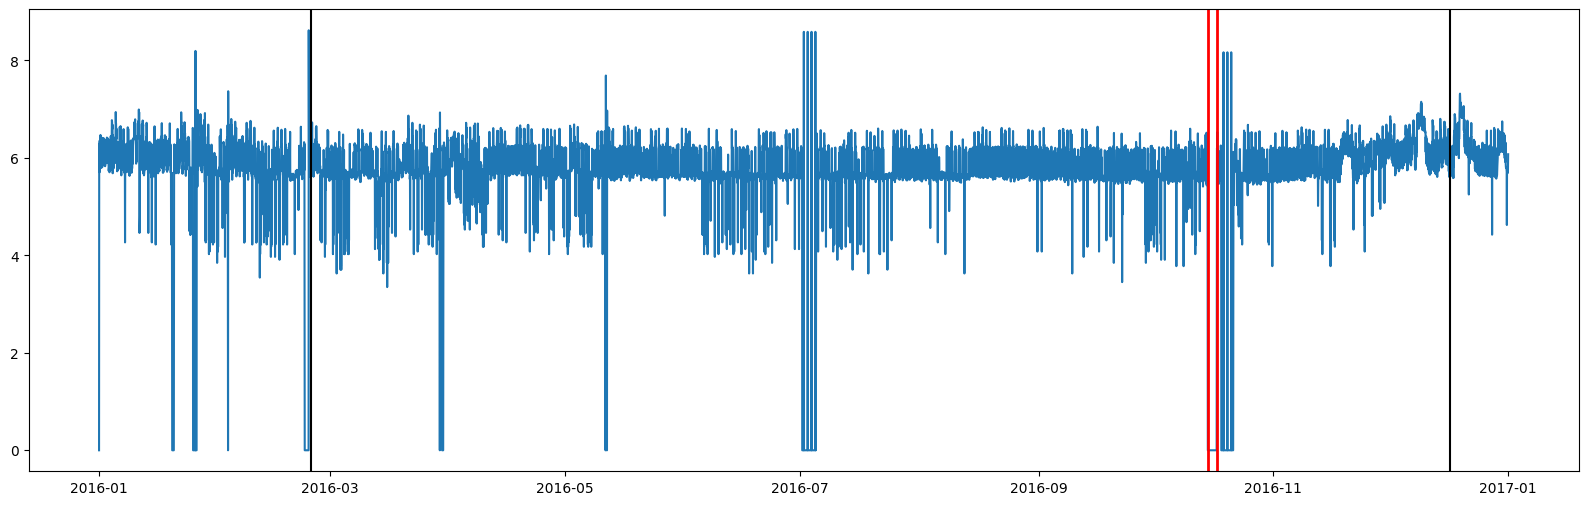

In [67]:
# meter_id: type -> {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}

meter_id = 2
building_id = 879

bm_df = readings_df[(readings_df["building_id"] == building_id) & (readings_df["meter_id"] == meter_id)]
streaks = find_constant_streaks(bm_df, streak_length=35)

fig, ax = plt.subplots(1, 1, figsize=(20, 6))
ax.plot(
    bm_df["timestamp"].values,
    bm_df["ln_meter_reading"].values,
)

for start, end in streaks:
    print(start, end)
    ax.axvline(start, lw=2, color="red")
    ax.axvline(end, lw=2, color="red")

ax.axvline(datetime(2016, 2, 25, 0), color="black")
ax.axvline(datetime(2016, 12, 16, 23), color="black")

In [ ]:
to_keep = {
    751: [(datetime(2016, 2, 3, 7), None)],
    758: [(None, datetime(2016, 2, 3, 7, 14))],
    759: [(None, datetime(2016, 1, 14, 23)), (datetime(2016, 2, 2, 8), None)],
    762: [(None, datetime(2016, 2, 25))],
    766: [(datetime(2016, 2, 3, 7), None)],
    772: [(datetime(2016, 2, 25, 7), datetime(2016, 3, 16, 7)), (datetime(2016, 12, 16, 23), None)],
    783: [(datetime(2016, 12, 9, 14), None)],
}

# streak_length=35
to_remove = [750, 776, 784, 876]